In [1]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import os
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# read the file
purchase_df=pd.read_csv('Purchase.csv')

In [3]:
#drop unecessary variables 
purchase_df=purchase_df.drop(columns=['MobilePanel','FixedPanel','purchase_own','purchase_any'])
#drop NaN
purchase_df.dropna(subset=["TIMESPSS","Duration","DEVICE_TYPE","type_touch"],inplace=True)

In [4]:
#regroup type of touch
purchase_df['type_touch']=purchase_df['type_touch'].replace([2,3],1)
purchase_df['type_touch']=purchase_df['type_touch'].replace([4,5,6],2)
purchase_df['type_touch']=purchase_df['type_touch'].replace([7,8,9],3)
purchase_df['type_touch']=purchase_df['type_touch'].replace([10,12],4)
purchase_df['type_touch']=purchase_df['type_touch'].replace([13,14,15],5)
purchase_df['type_touch']=purchase_df['type_touch'].replace([16],6)

purchase_df=pd.get_dummies(purchase_df, columns=["type_touch"], prefix=["touch"])

In [5]:
# convert the column type to floats for multiplication 
purchase_df['touch_1']=purchase_df['touch_1'].astype('float64')
purchase_df['touch_2']=purchase_df['touch_2'].astype('float64')
purchase_df['touch_3']=purchase_df['touch_3'].astype('float64')
purchase_df['touch_4']=purchase_df['touch_4'].astype('float64')
purchase_df['touch_5']=purchase_df['touch_5'].astype('float64')
purchase_df['touch_6']=purchase_df['touch_6'].astype('float64')

In [6]:
#Calculate the total number of interactions per purchase ID (sum of touchpoints)
weight1_df=purchase_df.groupby(['UserID','PurchaseID'])[['touch_1','touch_2','touch_3','touch_4','touch_5','touch_6']].sum().reset_index()
weight1_df['total_interaction']=weight1_df[['touch_1','touch_2','touch_3','touch_4','touch_5','touch_6']].sum(axis=1)

In [7]:
#Transform number of interaction of each touch points into length of duration on each touch points 
purchase_df['touch1']=purchase_df['touch_1']*purchase_df['Duration']
purchase_df['touch2']=purchase_df['touch_2']*purchase_df['Duration']
purchase_df['touch3']=purchase_df['touch_3']*purchase_df['Duration']
purchase_df['touch4']=purchase_df['touch_4']*purchase_df['Duration']
purchase_df['touch5']=purchase_df['touch_5']*purchase_df['Duration']
purchase_df['touch6']=purchase_df['touch_6']*purchase_df['Duration']

In [8]:
purchase_df.DEVICE_TYPE=purchase_df.DEVICE_TYPE.replace("MOBILE",0)
purchase_df.DEVICE_TYPE=purchase_df.DEVICE_TYPE.replace("FIXED",1)

In [9]:
purchase_df.head()

,UserID,PurchaseID,TIMESPSS,Duration,DEVICE_TYPE,touch_1,touch_2,touch_3,touch_4,touch_5,touch_6,touch1,touch2,touch3,touch4,touch5,touch6
0,9558,1,12/3/2016 22:18,5.786,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.786,0.0,0.0,0.0
1,9558,1,13/3/2016 5:25,65.725,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65.725,0.0,0.0,0.0
2,9558,1,13/3/2016 12:26,6.492,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.492,0.0,0.0,0.0
3,9657,2,18/7/2015 13:00,57.000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,57.0,0.000,0.0,0.0,0.0
4,1,3,7/8/2015 19:16,120.000,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,120.000,0.0,0.0,0.0


In [10]:
#Consolidate the duration of each touch points 
#Reset index by using groupby with functions sum to understand user time spend on each touch point per puchase ID 
weight2_df=purchase_df.groupby(['UserID','PurchaseID'])['Duration','touch1','touch2','touch3','touch4','touch5','touch6'].sum().reset_index()

<ipython-input-10-4ce366303a6b>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  weight2_df=purchase_df.groupby(['UserID','PurchaseID'])['Duration','touch1','touch2','touch3','touch4','touch5','touch6'].sum().reset_index()


In [11]:
#Reset index by using groupby with function mean to understand user's preference per puchase ID
weight3_df=purchase_df.groupby(['UserID','PurchaseID'])['DEVICE_TYPE'].mean().reset_index()

In [12]:
#Calculate journey length 
purchase_df['TIMESPSS']=pd.to_datetime(purchase_df['TIMESPSS'])
weight4_df=purchase_df.drop(columns=['DEVICE_TYPE','touch1','touch2','touch3','touch4','touch5','touch6'])

weight4_df.sort_values(['PurchaseID'], inplace=True) 
weight4_df['Journey Length']=\
   [int(n.days)if n > pd.Timedelta(days=1) else "0" if pd.notnull(n) else "0" 
   for n in weight4_df.groupby(['UserID','PurchaseID'])['TIMESPSS'].diff()]

weight4_df['Journey Length']=weight4_df['Journey Length'].astype('int64')

weight4_df=weight4_df.groupby(['UserID','PurchaseID'])['Journey Length'].max().reset_index()


In [13]:
#Merge weight1 weight2 weight3 weight4 into weight_final 
weight_final_df=pd.merge(weight1_df,weight2_df, on=['PurchaseID','UserID'])
weight_final_df=pd.merge(weight_final_df,weight3_df, on=['PurchaseID','UserID'])
weight_final_df=pd.merge(weight_final_df,weight4_df, on=['PurchaseID','UserID'])

In [14]:
#final touchpoint weighting
weight_final_df[['touch1','touch2','touch3','touch4','touch5','touch6']]=weight_final_df[['touch1','touch2','touch3','touch4','touch5','touch6']].div(weight_final_df.Duration, axis=0)

In [15]:
#normalise data 
from sklearn import preprocessing
scaler=MinMaxScaler() 
weight_final_df['Duration']=scaler.fit_transform(weight_final_df[['Duration']].values.reshape(-1,1))
weight_final_df['Journey Length']=scaler.fit_transform(weight_final_df[['Journey Length']].values.reshape(-1,1))
weight_final_df['total_interaction']=scaler.fit_transform(weight_final_df[['total_interaction']].values.reshape(-1,1))

In [16]:
#drop any nan 
weight_final_df.dropna(subset=["Duration",'touch1','touch2','touch3','touch4','touch5','touch6',"DEVICE_TYPE", "Journey Length","total_interaction"], inplace=True)


In [17]:
weight_final_df.to_excel('weight_purchase_final.xlsx')

In [18]:
weight_final_df.head()

,UserID,PurchaseID,touch_1,touch_2,touch_3,touch_4,touch_5,touch_6,total_interaction,Duration,touch1,touch2,touch3,touch4,touch5,touch6,DEVICE_TYPE,Journey Length
0,1,3,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000034,0.0,0.000000,1.000000,0.0,0.000000,0.000000,1.0,0.000000
1,1,4,5.0,0.0,0.0,0.0,0.0,0.0,0.000062,0.000258,1.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.392097
2,1,5,0.0,0.0,1.0,0.0,1.0,1.0,0.000031,0.000086,0.0,0.000000,0.504263,0.0,0.159007,0.336731,1.0,0.196049
3,2,6,0.0,25.0,0.0,0.0,0.0,2.0,0.000403,0.000233,0.0,0.866747,0.000000,0.0,0.000000,0.133253,0.0,0.284195
4,2,7,0.0,0.0,0.0,0.0,0.0,2.0,0.000016,0.000007,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000


In [19]:
#find correltaions between varibales 
corr=weight_final_df[["Duration",'touch1','touch2','touch3','touch4','touch5','touch6',"DEVICE_TYPE", "Journey Length","total_interaction"]].corr()
print(corr)


                   Duration    touch1    touch2    touch3    touch4    touch5  \
Duration           1.000000 -0.008575 -0.012980  0.009942  0.017634  0.025182   
touch1            -0.008575  1.000000 -0.299397 -0.538603 -0.142297 -0.279901   
touch2            -0.012980 -0.299397  1.000000 -0.249572 -0.054510 -0.115274   
touch3             0.009942 -0.538603 -0.249572  1.000000 -0.048708 -0.213209   
touch4             0.017634 -0.142297 -0.054510 -0.048708  1.000000 -0.057081   
touch5             0.025182 -0.279901 -0.115274 -0.213209 -0.057081  1.000000   
touch6            -0.026004 -0.201259 -0.080522 -0.171838 -0.041182 -0.082565   
DEVICE_TYPE        0.028397  0.000626 -0.065731  0.071721 -0.004165  0.008781   
Journey Length     0.173913  0.017323 -0.033681  0.051721  0.026037  0.006357   
total_interaction  0.983099 -0.006745 -0.010107  0.006382  0.020703  0.023007   

                     touch6  DEVICE_TYPE  Journey Length  total_interaction  
Duration          -0.026004   

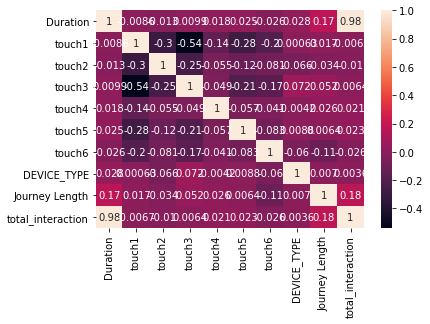

In [20]:
#plot correlation results into heat map 
sns.heatmap(corr, annot=True)
plt.show()